In [ ]:
from google.colab import drive
import json
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import defaultdict
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import warnings

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/CSCI566/'

Mounted at /content/drive


In [ ]:
folder_path = file_path
df = pd.read_csv(folder_path + 'elo-50-22.csv',parse_dates=['date'])
df = df[df['date'].dt.year >= 1950]

df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
2162,1950-09-16,1950,0,NaN,PHI,CLE,1674.314,1647.304,0.629402,0.370598,...,275.22,-12.309,27.522,1630.613026,1685.827280,10,35,98.0,NaN,NaN
2163,1950-09-17,1950,0,NaN,BCL,WSH,1337.541,1454.448,0.425851,0.574149,...,251.79,0.363,25.179,1310.867671,1481.487455,14,38,6.0,NaN,NaN
2164,1950-09-17,1950,0,NaN,PIT,NYG,1485.849,1461.717,0.625529,0.374471,...,-54.12,-3.498,-5.412,1454.118729,1493.988602,7,18,35.0,NaN,NaN
2165,1950-09-17,1950,0,NaN,GB,DET,1353.646,1449.128,0.456245,0.543755,...,115.17,-3.762,11.517,1322.441687,1481.661757,7,45,7.0,NaN,NaN
2166,1950-09-17,1950,0,NaN,LAR,CHI,1564.606,1628.688,0.501321,0.498679,...,-30.03,-1.221,-3.003,1549.226817,1643.798965,20,24,88.0,NaN,NaN


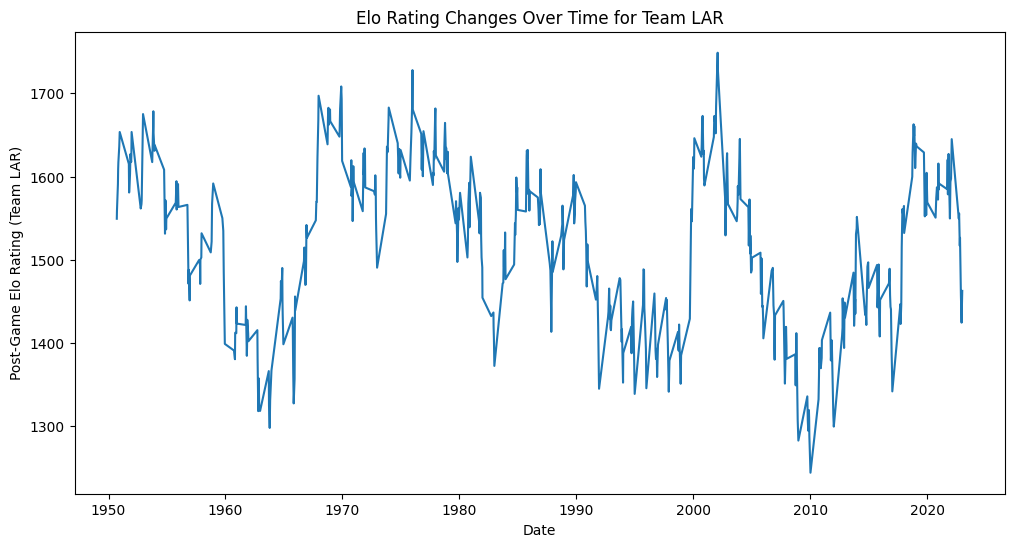

In [ ]:
#ELO Trends over time for LA Rams
team_df = df[df['team1'] == 'LAR']


plt.figure(figsize=(12, 6))
sns.lineplot(data=team_df, x='date', y='qbelo1_post')
plt.title('Elo Rating Changes Over Time for Team LAR')
plt.xlabel('Date')
plt.ylabel('Post-Game Elo Rating (Team LAR)')
plt.show()


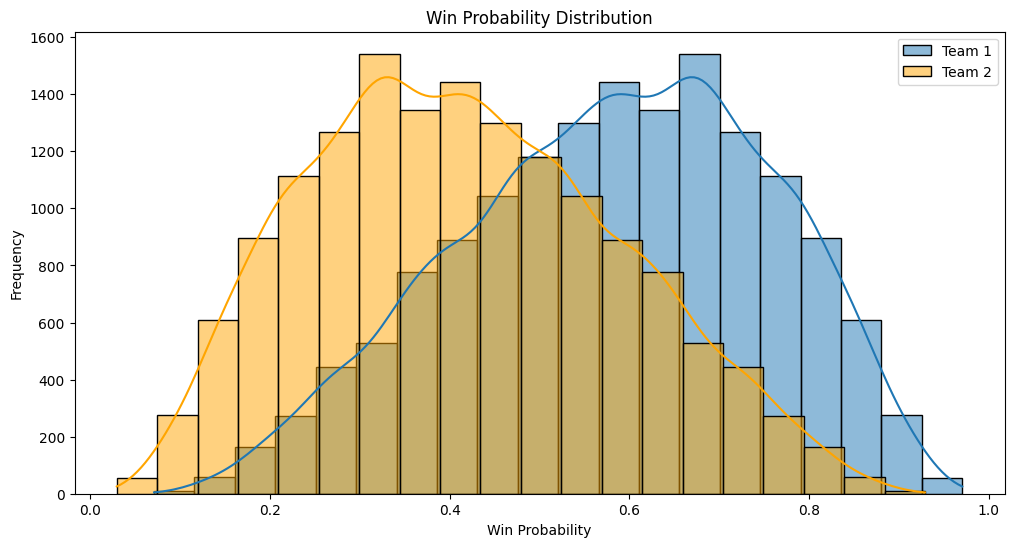

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['elo_prob1'], bins=20, kde=True, label='Team 1')
sns.histplot(df['elo_prob2'], bins=20, kde=True, color='orange', label='Team 2')
plt.title('Win Probability Distribution')
plt.xlabel('Win Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<ipython-input-9-0fd4535d0aa3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_games['home_win'] = (home_games['score1'] > home_games['score2']).astype(int)


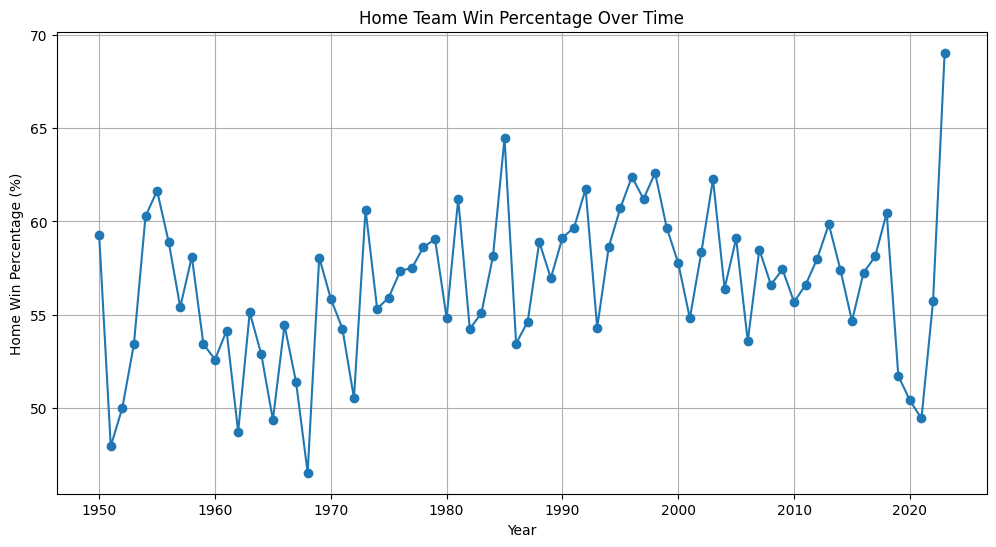

In [ ]:
home_games = df[df['neutral'] == 0]

# Create a column to indicate if the home team won

home_games['home_win'] = (home_games['score1'] > home_games['score2']).astype(int)

#Group by season and calculate the win percentage for home teams
win_percentage = home_games.groupby(home_games['date'].dt.year)['home_win'].mean() * 100

# Plot the home team win percentage over time
plt.figure(figsize=(12, 6))
plt.plot(win_percentage.index, win_percentage.values, marker='o')
plt.title('Home Team Win Percentage Over Time')
plt.xlabel('Year')
plt.ylabel('Home Win Percentage (%)')
plt.grid(True)
plt.show()

<ipython-input-10-37f44a0cb36b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_games['away_win'] = (away_games['score2'] > away_games['score1']).astype(int)


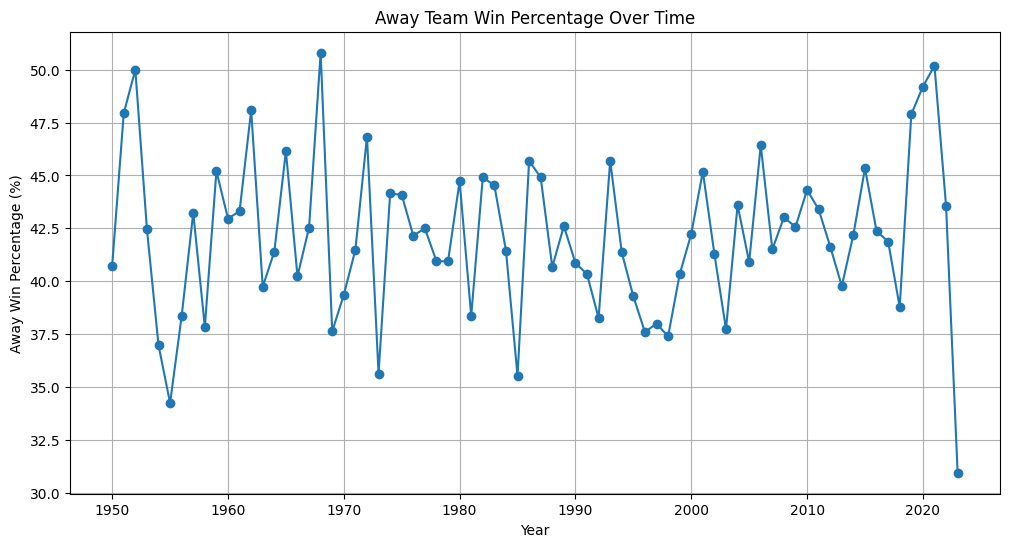

In [ ]:
away_games = df[df['neutral'] == 0]

# Create a column to indicate if the home team won

away_games['away_win'] = (away_games['score2'] > away_games['score1']).astype(int)

# Group by season (or year) and calculate the win percentage for home teams
win_percentage = away_games.groupby(away_games['date'].dt.year)['away_win'].mean() * 100

# Plot the home team win percentage over time
plt.figure(figsize=(12, 6))
plt.plot(win_percentage.index, win_percentage.values, marker='o')
plt.title('Away Team Win Percentage Over Time')
plt.xlabel('Year')
plt.ylabel('Away Win Percentage (%)')
plt.grid(True)
plt.show()

In [ ]:
df.tail()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
17374,2023-01-22,2022,0,d,BUF,CIN,1731.516093,1690.292481,0.648277,0.351723,...,303.726984,225.069808,230.466056,1675.570770,1690.152492,10,27,99.0,100.0,100.0
17375,2023-01-22,2022,0,d,SF,DAL,1708.971847,1640.135262,0.683613,0.316387,...,105.114287,109.133365,191.883277,1719.153115,1619.647034,19,12,98.0,100.0,99.0
17376,2023-01-29,2022,0,c,PHI,SF,1621.987292,1721.375447,0.450672,0.549328,...,56.917741,246.826740,103.911803,1645.507079,1693.213858,31,7,99.0,100.0,100.0
17377,2023-01-29,2022,0,c,KC,CIN,1735.804844,1729.668918,0.600966,0.399034,...,28.185998,280.177715,210.238050,1708.664922,1678.805820,23,20,100.0,100.0,100.0
17378,2023-02-12,2022,1,s,PHI,KC,1657.913193,1746.521889,0.375176,0.624824,...,411.098145,268.147365,293.269758,1633.804536,1720.367465,35,38,100.0,100.0,100.0


In [ ]:
df.columns

Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'qbelo1_pre', 'qbelo2_pre', 'qb1', 'qb2', 'qb1_value_pre',
       'qb2_value_pre', 'qb1_adj', 'qb2_adj', 'qbelo_prob1', 'qbelo_prob2',
       'qb1_game_value', 'qb2_game_value', 'qb1_value_post', 'qb2_value_post',
       'qbelo1_post', 'qbelo2_post', 'score1', 'score2', 'quality',
       'importance', 'total_rating'],
      dtype='object')

In [ ]:
df.isnull().sum()

,0
date,0
season,0
neutral,0
playoff,14628
team1,0
team2,0
elo1_pre,0
elo2_pre,0
elo_prob1,0
elo_prob2,0


In [ ]:
df.loc[(df.score1 > df.score2), "result"] = 1
df.result.fillna(0, inplace=True)

# Removing the 1950 - 1980 Seasons
for i in range(1950, 1980):
    df = df[df["season"] != i]

df = df.drop(columns = ["date", "score1", "score2", "playoff", "qb1", "qb2", "team1", "team2"])

# Dropping all columns with 'post'
for column_name in df.columns:
    if "post" in column_name:
        df = df.drop(columns = column_name)

# Combining qb1 and qb2 values
df["qb1_relative"] = df["qb1_game_value"] - df["qb2_game_value"]
df["qb1_pre_relative_value"] = df["qb1_value_pre"] - df["qb2_value_pre"]
df["qb1_relative_adj"] = df["qb1_adj"] - df["qb2_adj"]

df = df.drop(columns = ["qb1_game_value", "qb2_game_value", "qb1_value_pre","qb2_value_pre", "elo_prob2", "qb1_adj", "qb2_adj", "qbelo_prob2"])

# Renaming columns
df.rename(columns = {"elo_prob1": "pred_home_win", "qbelo_prob1": "pred_homeQB_win"}, inplace = True)

df['quality'] = df['quality'].fillna(
    100 * (2 * df['elo1_pre'] * df['elo2_pre']) / (df['elo1_pre'] + df['elo2_pre'])
)

# Fill missing values in 'importance' with the approximate formula based on elo differences
df['importance'] = df['importance'].fillna(
    100 * (1 - abs(df['elo1_pre'] - df['elo2_pre']) / (df['elo1_pre'] + df['elo2_pre']))
)

# Fill missing values in 'total_rating' as the average of quality and importance
df['total_rating'] = df['total_rating'].fillna(
    (df['quality'] + df['importance']) / 2
)



<ipython-input-14-b6f3277c82fc>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.result.fillna(0, inplace=True)


In [ ]:
df.isnull().sum()

,0
season,0
neutral,0
elo1_pre,0
elo2_pre,0
pred_home_win,0
qbelo1_pre,0
qbelo2_pre,0
pred_homeQB_win,0
quality,0
importance,0


In [ ]:
train = df.copy()
dev = df.copy()
test = df.copy()
train = train.loc[train['season'] < 2015]
dev = dev.loc[(dev['season'] >= 2015) & (dev['season'] < 2018)]
test = test.loc[test['season'] > 2018]

X_train = train.drop(columns = ["result"])
y_train = train["result"]
X_dev = dev.drop(columns = ["result"])
y_dev = dev["result"]
X_test = test.drop(columns = ["result"])
y_test = test["result"]

X_train.head()

,season,neutral,elo1_pre,elo2_pre,pred_home_win,qbelo1_pre,qbelo2_pre,pred_homeQB_win,quality,importance,total_rating,qb1_relative,qb1_pre_relative_value,qb1_relative_adj
6555,1980,0,1465.161,1546.464,0.476555,1461.832866,1547.698661,0.460224,49.0,97.300361,73.150181,-67.068935,4.971317,-1.229679
6556,1980,0,1470.732,1460.770,0.606236,1466.536871,1464.160691,0.569589,24.0,99.660174,61.830087,-255.150297,6.367710,-11.820129
6557,1980,0,1505.008,1364.838,0.765137,1497.963718,1358.733383,0.757095,17.0,95.115766,56.057883,76.268129,26.571479,-4.573281
6558,1980,0,1532.664,1609.009,0.483679,1527.640860,1599.671937,0.489849,80.0,97.569925,88.784963,-235.196602,14.145632,6.237626
6559,1980,0,1500.393,1433.619,0.681039,1496.851462,1438.022848,0.652097,32.0,97.724140,64.862070,-247.158203,-24.610563,-4.890847


In [ ]:
# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
X_dev_tensor = torch.tensor(X_dev.values, dtype=torch.float)
y_dev_tensor = torch.tensor(y_dev.values, dtype=torch.float)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)

# Normalize Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Debugging
print(f"X_train_tensor.shape: {X_train_tensor.shape}")
print(f"y_train_tensor.shape: {y_train_tensor.shape}")
print(f"X_dev_tensor.shape: {X_dev_tensor.shape}")
print(f"y_dev_tensor.shape: {y_dev_tensor.shape}")
print(f"X_test_tensor.shape: {X_test_tensor.shape}")
print(f"y_test_tensor.shape: {y_test_tensor.shape}")

X_train_tensor.shape: torch.Size([8651, 14])
y_train_tensor.shape: torch.Size([8651])
X_dev_tensor.shape: torch.Size([801, 14])
y_dev_tensor.shape: torch.Size([801])
X_test_tensor.shape: torch.Size([1105, 14])
y_test_tensor.shape: torch.Size([1105])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy: 76.47%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.66      0.73       525
         1.0       0.74      0.86      0.79       580

    accuracy                           0.76      1105
   macro avg       0.77      0.76      0.76      1105
weighted avg       0.77      0.76      0.76      1105



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:38:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


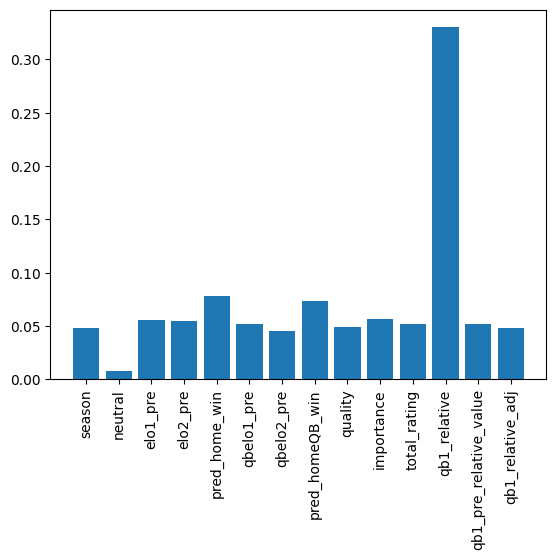

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:38:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy with selected features: 0.7378277153558053


In [ ]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)
importance = xgb.feature_importances_


plt.bar(X_train.columns, importance)
plt.xticks(rotation=90)
plt.show()


selected_features = X_train.columns[importance > 0.01]
X_train_selected = X_train[selected_features]
X_dev_selected = X_dev[selected_features]

xgb.fit(X_train_selected, y_train)
print("Accuracy with selected features:", xgb.score(X_dev_selected, y_dev))


In [ ]:
from sklearn.metrics import accuracy_score, classification_report


xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


xgb_classifier.fit(X_train, y_train)


y_pred_xgb = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {accuracy_xgb * 100:.2f}%')
print('\nClassification Report:\n', classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:38:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 74.03%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.68      0.71       525
         1.0       0.73      0.79      0.76       580

    accuracy                           0.74      1105
   macro avg       0.74      0.74      0.74      1105
weighted avg       0.74      0.74      0.74      1105



# ML Method 1: Neural Network

## MLP Class Definition

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, width=10, depth=5, out_dim=1, activation='tanh'):
        super(MLP, self).__init__()

        # Activations
        if activation == 'tanh':
          self.activation = nn.Tanh()
        elif activation == 'sin':
          self.activation = torch.sin

        # Need to ensure there is at least one hidden layer
        assert depth > 1

        # First hidden layer
        MLP_list = [nn.Linear(input_dim, width)]

        # Remaining hidden layers
        for _ in range(depth - 1):
            MLP_list.append(nn.Linear(width, width))

        # Output layer
        MLP_list.append(nn.Linear(width, out_dim))

        # Adding list of layers as modules
        self.model = nn.ModuleList(MLP_list)

        # Weights initialization
        def init_weights(layer):
          if isinstance(layer, nn.Linear):
              nn.init.uniform_(layer.weight, -1, 1)
              if layer.bias is not None:
                nn.init.uniform_(layer.bias, -1, 1)

        self.model.apply(init_weights)

    def forward(self, x):
        for i, layer in enumerate(self.model):
          if i < len(self.model) - 1:
            x = self.activation(layer(x))
          else:
            x = torch.sigmoid(layer(x))  # No activation in the final layer, predicting values instead of probabilities

        return x

class Sine(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)

In [ ]:
def train_NN1(model, optimizer, criterion, max_epochs):

    # Lists to store metrics for each epoch
    train_loss_history = []
    dev_loss_history = []
    dev_set_delta = []

    # Training loop
    for epoch in tqdm(range(max_epochs)):

        # Zero the gradients
        optimizer.zero_grad() # Sets the gradients of all optimized torch.Tensor s to zero.

        # Forward pass
        y_pred = model(X_train_tensor)

        # Compute the loss
        loss = criterion(y_pred, y_train_tensor.unsqueeze(1))

        # Backpropagation
        loss.backward() # Computes the gradient of current tensor w.r.t. graph leaves.

        # Update the weights
        optimizer.step() # Performs a single optimization step (parameter update).

        # Calculate and store training loss
        train_loss_history.append(np.sqrt(loss.item()))

        # Calculate validation loss
        with torch.no_grad():  # Disables gradient calculation
            model.eval()
            dev_pred = model(X_dev_tensor)
            dev_loss = criterion(dev_pred, y_dev_tensor.unsqueeze(1))
            dev_loss_history.append(np.sqrt(dev_loss.item()))

            # Return to training mod
            model.train()

    return train_loss_history, dev_loss_history

def test_NN1(model, criterion):
    print(f"Evaluating Final Model: ")  # Predicts y based on x_test
    test_loss_history = []
    with torch.no_grad():
        model.eval()
        logits = model(X_test_tensor)
        print(logits)
        print(y_test_tensor)
        #pred_labels = torch.argmax(pred, dim=1)
        #test_loss = criterion(pred, y_test_tensor)
        y_preds = (logits >= 0.5).float()  # Choose argmax for each row (i.e., collapse dimension 1, hence dim=1)
        acc = torch.mean((y_preds == y_test_tensor.numpy()).float()).item()
        test_loss_history.append(acc)

    for loss in test_loss_history:
        print(f"Test Loss: {loss}")

    return y_preds, test_loss_history

# Testing

100%|██████████| 50000/50000 [07:25<00:00, 112.28it/s]


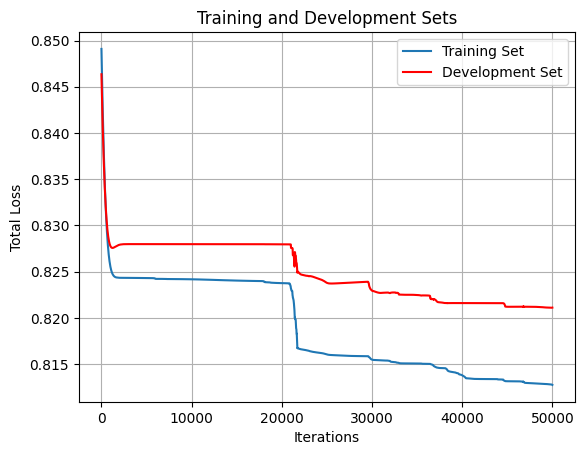

In [ ]:
# Set Model Parameters
input_dim = 14  # Team Statistics: (season 	neutral 	elo1_pre 	elo2_pre 	pred_home_win 	qbelo1_pre 	qbelo2_pre 	pred_homeQB_win 	quality 	importance 	total_rating 	qb1_relative 	qb1_pre_relative_value 	qb1_relative_adj))
out_dim = 1 # One output layer: the outcome of the game 1.0 means the home team won otherwise the away team

# Arbitrary Parameters
width = 10
depth = 5
learning_rate = 1e-5
reg_param = 1e-6
max_epochs = 50000

# Define Loss, Model, and Optimizer
criterion = nn.BCELoss()
model = MLP(input_dim=input_dim, width=width, depth=depth, out_dim=out_dim, activation='tanh')
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_param)

# Run Training Loop
train_loss_history, dev_loss_history = train_NN1(model, optimizer, criterion, max_epochs)

# Create a single plot for training and validation sets
plt.plot(train_loss_history, label='Training Set')
plt.plot(dev_loss_history, label='Development Set', color='red')
plt.xlabel('Iterations')
plt.ylabel('Total Loss')
plt.title('Training and Development Sets')
plt.legend()
plt.grid(True)
plt.show()

Evaluating Final Model: 
tensor([[0.5668],
        [0.5668],
        [0.5668],
        ...,
        [0.5668],
        [0.5668],
        [0.5668]])
tensor([0., 1., 0.,  ..., 1., 1., 0.])
Test Loss: 0.5248869061470032


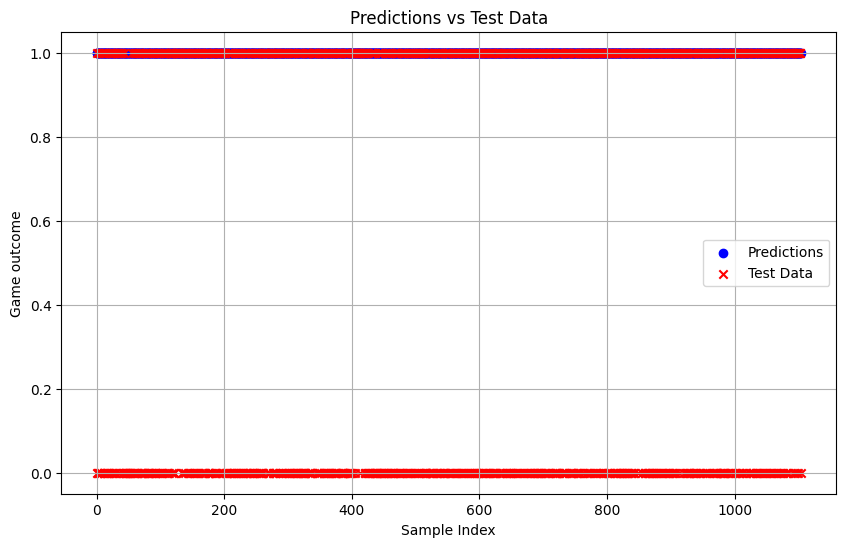

In [ ]:
# Run Testing
pred, test_loss_history = test_NN1(model, criterion)

# Squeeze the prediction and true value tensors to 1D arrays for plotting
ped_prob = pred
y_test_1d = y_test_tensor.squeeze()

plt.figure(figsize=(10, 6))
plt.scatter(range(len(ped_prob)), ped_prob.cpu().detach().numpy(), label='Predictions', color='blue', marker='o')
plt.scatter(range(len(y_test_tensor)), y_test_tensor.cpu().numpy(), label='Test Data', color='red', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Game outcome')
plt.title('Predictions vs Test Data')
plt.legend()

plt.grid(True)
plt.show()

**LSTM**

In [ ]:
def create_sequences(df, results_column='result', sequence_length=5):
    """
    Creates sequences of past games for use in LSTM models, considering preprocessed data.

    Args:
        df (pd.DataFrame): DataFrame with preprocessed game data, including results and other features.
        results_column (str): Column name for the match outcome (1 if team1 wins, 0 if team2 wins).
        sequence_length (int): Number of past games to include in each sequence.

    Returns:
        np.array: Sequences of features (X).
        np.array: Corresponding labels (y).
    """
    sequences, labels = [], []


    df = df.sort_values(by=['season'])


    feature_columns = [
        'elo1_pre', 'elo2_pre', 'pred_home_win', 'pred_homeQB_win', 'quality',
        'importance', 'total_rating', 'qb1_relative', 'qb1_pre_relative_value', 'qb1_relative_adj'
    ]


    df = df[feature_columns + [results_column]].dropna()

    # Generate sequences
    features = df[feature_columns].values
    labels_list = df[results_column].values

    for i in range(sequence_length, len(features)):
        sequences.append(features[i - sequence_length:i])  # Past games as features
        labels.append(labels_list[i])  # Current game's result as label

    return np.array(sequences), np.array(labels)


In [ ]:


train = df.copy()
dev = df.copy()
test = df.copy()
train = train.loc[train['season'] < 2017]
dev = dev.loc[(dev['season'] >= 2017) & (dev['season'] < 2018)]
test = test.loc[test['season'] > 2018]



# Create sequences for training, validation, and test datasets
sequence_length = 5

X_train, y_train = create_sequences(train, results_column='result', sequence_length=sequence_length)
X_val, y_val = create_sequences(dev, results_column='result', sequence_length=sequence_length)
X_test, y_test = create_sequences(test,results_column='result', sequence_length=sequence_length)

# Check shapes
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (9180, 5, 10) (9180,)
Validation set: (262, 5, 10) (262,)
Test set: (1100, 5, 10) (1100,)


In [ ]:
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Check shapes
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (9180, 2)
y_val shape: (262, 2)
y_test shape: (1100, 2)


In [ ]:
model = Sequential([
    LSTM(64, input_shape=(sequence_length, X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')  # Binary classification (win/loss)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


287/287 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5829 - loss: 0.6815 - val_accuracy: 0.5687 - val_loss: 0.6836
Epoch 2/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5725 - loss: 0.6829 - val_accuracy: 0.5687 - val_loss: 0.6846
Epoch 3/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5783 - loss: 0.6807 - val_accuracy: 0.5687 - val_loss: 0.6837
Epoch 4/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5803 - loss: 0.6808 - val_accuracy: 0.5687 - val_loss: 0.6837
Epoch 5/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5817 - loss: 0.6801 - val_accuracy: 0.5687 - val_loss: 0.6859
Epoch 6/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5847 - loss: 0.6793 - val_accuracy: 0.5687 - val_loss: 0.6839
Epoch 7/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5747 - loss: 0.6823 - val_accuracy: 0.5687 - val_loss: 0.6847
Epoch 8/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5824 - loss: 0.6796 - val_accuracy: 0.56

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout

# Define the RNN model
rnn_model = Sequential([
    SimpleRNN(64, input_shape=(sequence_length, X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')  # Binary classification (win/loss)
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate on the test set
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test)
print(f"RNN Test Loss: {rnn_loss:.4f}, RNN Test Accuracy: {rnn_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5669 - loss: 0.6903 - val_accuracy: 0.5687 - val_loss: 0.6851
Epoch 2/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5839 - loss: 0.6804 - val_accuracy: 0.5687 - val_loss: 0.6841
Epoch 3/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5893 - loss: 0.6781 - val_accuracy: 0.5687 - val_loss: 0.6838
Epoch 4/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5919 - loss: 0.6782 - val_accuracy: 0.5687 - val_loss: 0.6842
Epoch 5/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5843 - loss: 0.6796 - val_accuracy: 0.5687 - val_loss: 0.6836
Epoch 6/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5749 - loss: 0.6830 - val_accuracy: 0.5687 - val_loss: 0.6844
Epoch 7/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5738 - loss: 0.6835 - val_accuracy: 0.5687 - val_loss: 0.6846
Epoch 8/150
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5687 - loss: 0.6846 - val_accu